<font size=12>event timeline v. price</font>

# prep

In [40]:
import mitosheet
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random
import numpy as np
import requests
from datetime import datetime
import time

path_data1 = '/home/lstm/Downloads/df_fit - AxieInfinity.csv' # Axie Infinity

# read data & clean up

In [41]:
# read event data
df_events = pd.read_csv(path_data1, index_col='date', parse_dates=True)

# add non-overlapping random lead line value
df_events['lead'] = list(random.sample(range(1, len(df_events)+1), len(df_events)))

# convert to negative value for fin category
df_events['converter'] = [np.nan] * len(df_events)
df_events.loc[df_events.category=='dev', 'converter'] = 1
df_events.loc[df_events.category=='fin', 'converter'] = -1
df_events.lead = df_events.lead * df_events.converter

# add error bar value for minus and plus direction
df_events['e_minus'] = df_events.lead

# plot timeline

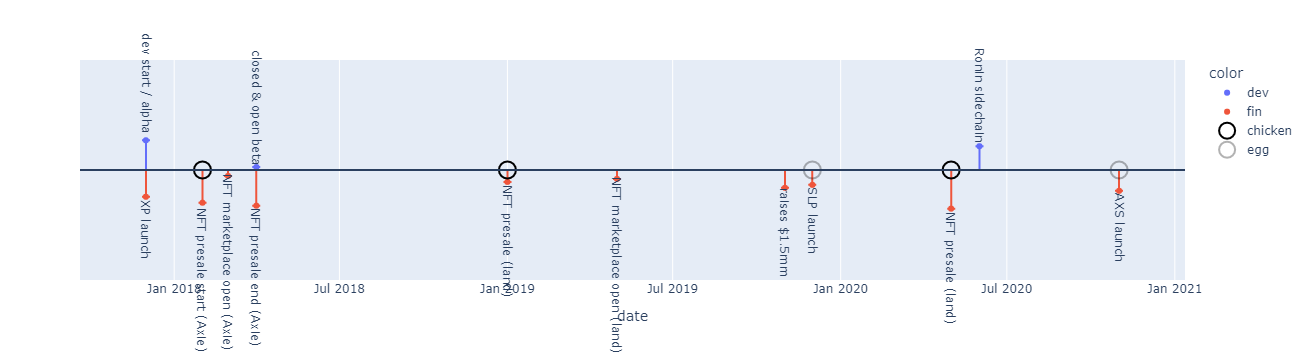

In [58]:
# plot w/ Express
fig = px.scatter(df_events.lead, color=df_events.category, error_y=df_events.lead * 0, error_y_minus=df_events.e_minus)#, labels=df_events.AxieInfinity)

# add horizontal line
fig.add_hline(y=0)

# rezie figure to accomodate annotations
ysize = max(df_events.lead) + max(df_events.event_name.apply(len))
fig.update_layout(yaxis_range=[ysize*-1, ysize])

# hide y axis
fig.update_yaxes(visible=False, showticklabels=False)

# add leadline & annotation, one by one

for idx, row in df_events.iterrows():
    leadline = row['lead'] + 2 +len(row['event_name']) if row['lead'] > 0 else row['lead'] - 2 - len(row['event_name'])
    # leadline = row['lead'] + 20 + len(row['AxieInfinity']) if row['lead'] > 0 else row['lead'] - 20 - len(row['AxieInfinity'])
    fig.add_annotation(text=row['event_name'],
                  # xref="paper", yref="paper",
                  x=idx, y=leadline, showarrow=False,
                  textangle=90)

# add chicken/egg event marker
marker_chicken = dict(color='rgba(0,0,0,0)', size=17, line=dict(color='Black', width=2))
marker_egg = dict(color='rgba(0,0,0,0)', size=17, line=dict(color='rgba(0,0,0,0.3)', width=2))
            
fig.add_trace(go.Scatter(x=df_events.index, y=df_events['chicken'], mode='markers', marker=marker_chicken, name='chicken'))
fig.add_trace(go.Scatter(x=df_events.index, y=df_events['egg'], mode='markers', marker=marker_egg, name='egg'))
    
fig.show()

# get market data from Binance (price)

In [ ]:
# get Binance symbols (USDT pairs)
result = requests.get('https://api.binance.com/api/v3/ticker/price')
js = result.json()
symbols = [x['symbol'] for x in js]
symbols_usdt = [x for x in symbols if 'USDT' in x]

In [ ]:
# define symbol, start, end, interval, endpoint
symbol = 'SLPUSDT'
start_date = '2017-01-01'  # Binance quotes available from 2017
end_date = datetime.today().strftime('%Y-%m-%d') # through today
interval = '1d'
URL = 'https://api.binance.com/api/v3/klines' # historical OHLV endpoint

if symbol not in symbols_usdt: raise ValueError('symbol not in symbol list')

# define column names
COLUMNS = ['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time', 'quote_av', 'trades', 
                   'tb_base_av', 'tb_quote_av', 'ignore']

In [ ]:
# get data
data = []

start = int(time.mktime(datetime.strptime(start_date + ' 00:00', '%Y-%m-%d %H:%M').timetuple())) * 1000
end = int(time.mktime(datetime.strptime(end_date +' 23:59', '%Y-%m-%d %H:%M').timetuple())) * 1000
params = {
    'symbol': symbol,
    'interval': interval,
    'limit': 1000,
    'startTime': start,
    'endTime': end
}

while start < end:
    print(datetime.fromtimestamp(start // 1000)) # //: floor division
    params['startTime'] = start
    result = requests.get(URL, params = params)
    js = result.json()
    if js: print('runinng period:', datetime.fromtimestamp(js[0][0] // 1000)) 
    else: break        
    data.extend(js)  
    start = js[-1][0] + 60000  # move on to next iteration (60k = 1000 mins)

if not data:  
    print('no data available for the period.') 
    # return -1

df = pd.DataFrame(data)
df.columns = COLUMNS

df['Open_time'] = df.apply(lambda x:datetime.fromtimestamp(x['Open_time'] // 1000), axis=1)
df = df.drop(columns = ['Close_time', 'ignore'])
df['Symbol'] = symbol
df.loc[:, 'Open':'tb_quote_av'] = df.loc[:, 'Open':'tb_quote_av'].astype(float)  # string to float
df['trades'] = df['trades'].astype(int)
mitosheet.sheet(df, view_df=True)

# get market data from Coingecko (market cap & price)
Using Coingecko community-built library:https://github.com/man-c/pycoingecko
Coingecko official doc: https://www.coingecko.com/en/api/documentation

In [59]:
# prep & get coin list
from pycoingecko import CoinGeckoAPI  # Community project. See: https://github.com/man-c/pycoingecko
import ipywidgets as widgets
from ipywidgets import HBox, Layout
import sys
sys.path.append('/home/lstm/Github/jp-codes-ubuntu/modules/')
import dummyf

cg = CoinGeckoAPI()
df_gecko = pd.DataFrame(cg.get_coins_list())

In [60]:
# check for symbol
check4 = ['slp', 'axs']
num_days = 5000

names = df_gecko.loc[df_gecko['symbol'].str.contains('|'.join(check4), case=False), :].name.to_list()
w_name = widgets.interactive(dummyf.dummyf, x=widgets.SelectMultiple(options=sorted(names), layout=Layout(width='400px', height='150px')))

HBox([widgets.Label('MLflow experiment name'), w_name])

In [61]:
list_names = w_name.kwargs['x']
list_sym = df_gecko.loc[df_gecko['name'].isin(list_names), :].id.to_list()

In [62]:
df_mktcap = pd.DataFrame()
df_price = pd.DataFrame()
for sym in list_sym:
    gecko_id = sym
    ticker = df_gecko.loc[df_gecko['id']==gecko_id, 'symbol'].iloc[0].upper()
    gecko_data = cg.get_coin_market_chart_by_id(gecko_id, vs_currency='USD', days=num_days)
    
    df_mc = pd.DataFrame(gecko_data['market_caps'])
    df_mc.columns = ['date', ticker]
    df_mc['date'] = df_mc['date'].div(1000).apply(datetime.fromtimestamp)
    df_mc.set_index('date', inplace=True)
    df_mc.index = pd.DatetimeIndex(df_mc.index.date)
    df_mc = df_mc.loc[~df_mc.index.duplicated(keep='last'), :]    
    df_mktcap = pd.concat([df_mktcap, df_mc], axis=1, join='outer')    

    df_pr = pd.DataFrame(gecko_data['prices'])
    df_pr.columns = ['date', ticker]
    df_pr['date'] = df_pr['date'].div(1000).apply(datetime.fromtimestamp)
    df_pr.set_index('date', inplace=True)
    df_pr.index = pd.DatetimeIndex(df_pr.index.date)
    df_pr = df_pr.loc[~df_pr.index.duplicated(keep='last'), :]    
    df_price = pd.concat([df_price, df_pr], axis=1, join='outer')
df_mktcap.sort_index(inplace=True)
df_mktcap.index.name = 'date'
df_price.sort_index(inplace=True)
df_price.index.name = 'date'

# plot market data over timeline

In [63]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# extend df_events index to match df_mktcap 
index_padding = df_mktcap.index[~df_mktcap.index.isin(df_events.index)]
df_padding = pd.DataFrame(index=index_padding)
df_events = pd.concat([df_events, df_padding]).sort_index()

# deal with nan values in new df_events
df_events['category'] = df_events['category'].fillna('n/a')
# df_events['lead'] = df_events['lead'].fillna(0)
# df_events['e_minus'] = df_events['e_minus'].fillna(0)

# extend df_mktcap index to match df_events
index_padding = df_events.index[~df_events.index.isin(df_mktcap.index)]
df_padding = pd.DataFrame(index=index_padding)
df_mktcap = pd.concat([df_mktcap, df_padding]).sort_index()

# do the same for df_price
index_padding = df_events.index[~df_events.index.isin(df_price.index)]
df_padding = pd.DataFrame(index=index_padding)
df_price = pd.concat([df_price, df_padding]).sort_index()

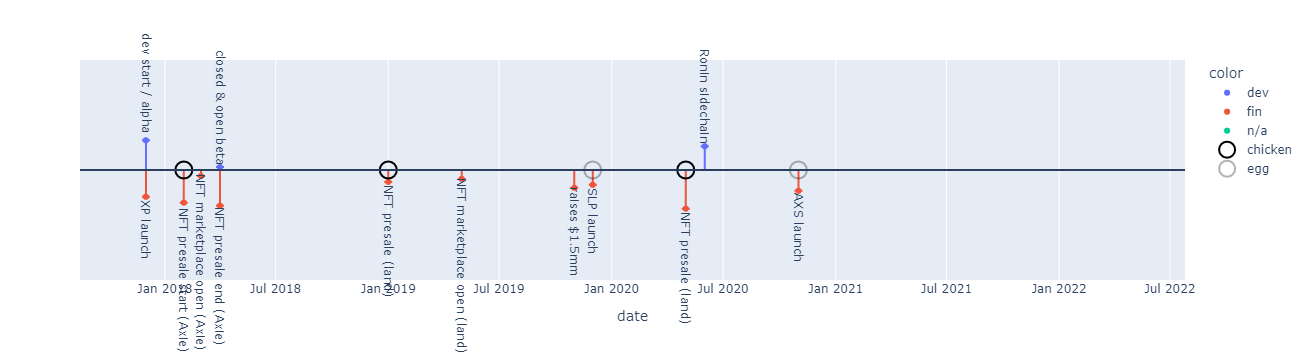

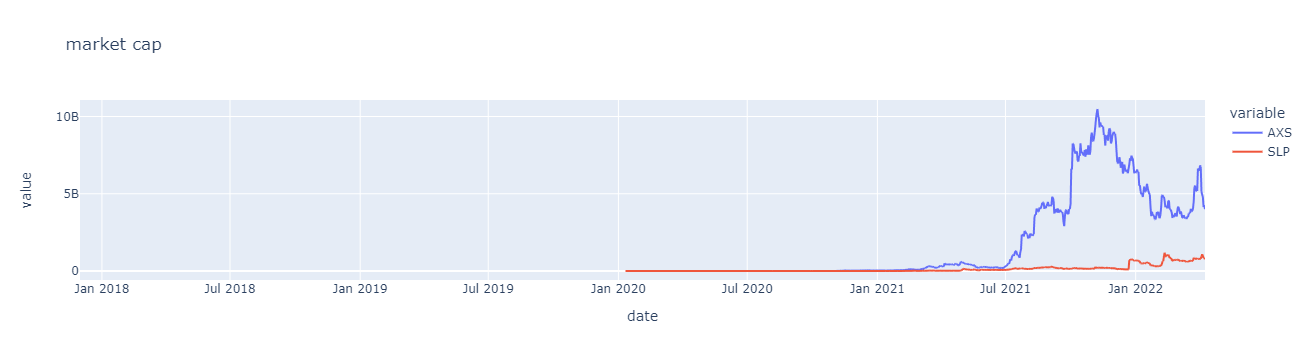

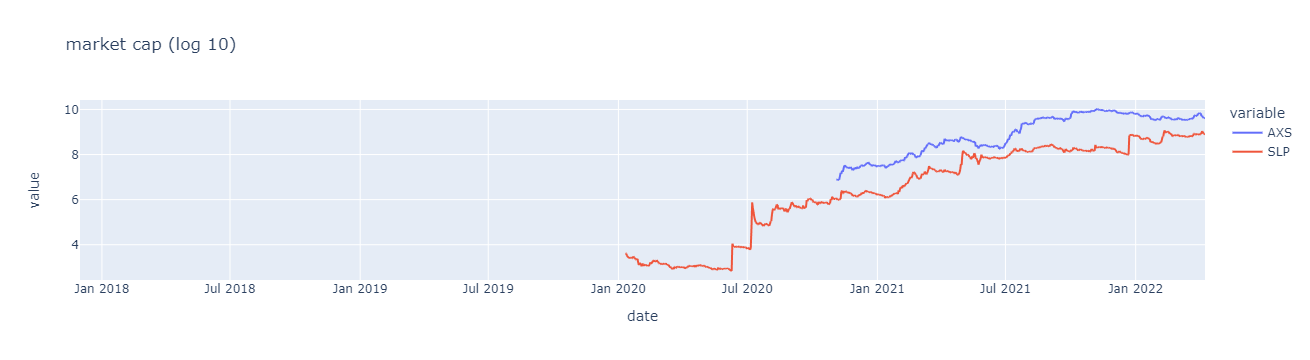

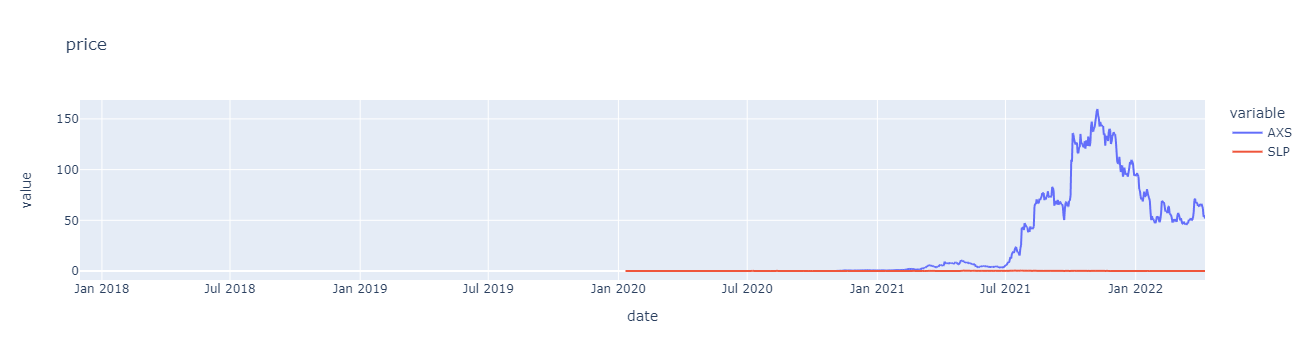

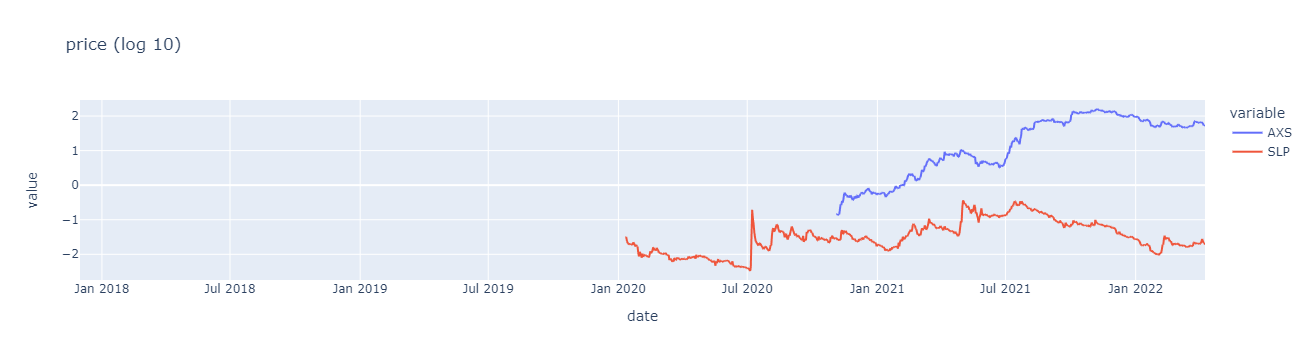

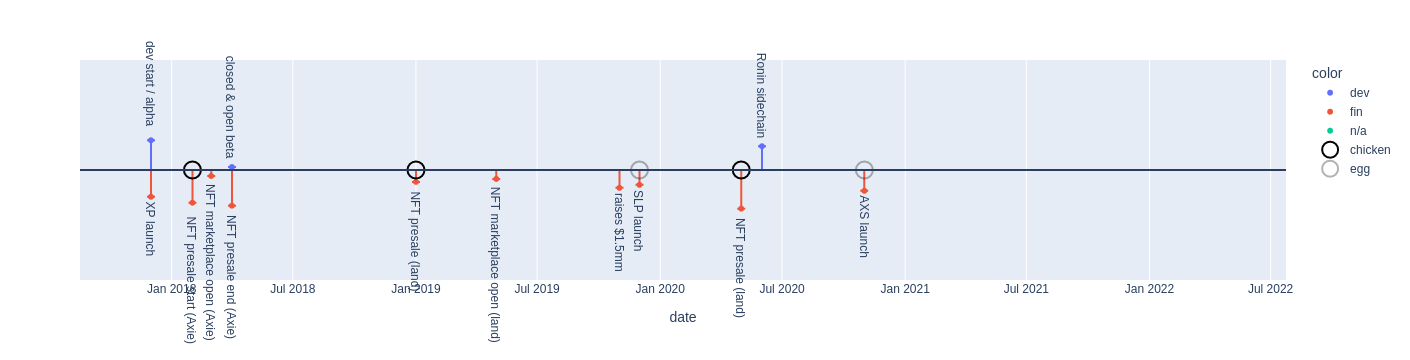

In [66]:
# plot
fig_timeline = px.scatter(df_events.lead, color=df_events.category, error_y=df_events.lead * 0, error_y_minus=df_events.e_minus)#, labels=df_events.AxieInfinity)
fig_timeline.add_hline(y=0)
ysize = max(df_events.lead) + max(df_events.event_name.dropna().apply(len))
fig_timeline.update_layout(yaxis_range=[ysize*-1, ysize])
fig_timeline.update_yaxes(visible=False, showticklabels=False)
for idx, row in df_events.iterrows():
    if ~np.isnan(row['lead']):
        leadline = row['lead'] + 2 + len(row['event_name']) if row['lead'] > 0 else row['lead'] - 2 - len(row['event_name'])
        fig_timeline.add_annotation(text=row['event_name'], x=idx, y=leadline, showarrow=False, textangle=90)
marker_chicken = dict(color='rgba(0,0,0,0)', size=17, line=dict(color='Black', width=2))
marker_egg = dict(color='rgba(0,0,0,0)', size=17, line=dict(color='rgba(0,0,0,0.3)', width=2))            
fig_timeline.add_trace(go.Scatter(x=df_events.index, y=df_events['chicken'], mode='markers', marker=marker_chicken, name='chicken'))
fig_timeline.add_trace(go.Scatter(x=df_events.index, y=df_events['egg'], mode='markers', marker=marker_egg, name='egg'))
    
fig_timeline.show()

fig1 = px.line(df_mktcap, title='market cap')
fig1.show()

fig2 = px.line(df_mktcap.apply(np.log10), title='market cap (log 10)')
fig2.show()

fig3 = px.line(df_price, title='price')
fig3.show()

fig4 = px.line(df_price.apply(np.log10), title='price (log 10)')
fig4.show()

fig_timeline.show()